In [4]:
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import sys
work_path = Path(next((p for p in Path("__file__").resolve().parents if p.name == "Research"), None))
torchlib_path = str(work_path / Path("app/torch_libs"))
sys.path.append(torchlib_path)

from run_manager import RunViewer


In [5]:
nb_path = Path().resolve()
rv = RunViewer(exp_path=nb_path)
df_base = rv.fetch_results(met_listed=False)


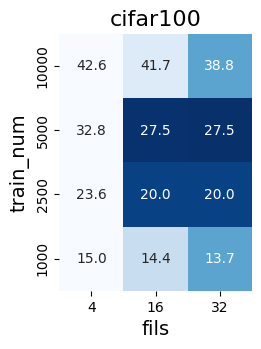

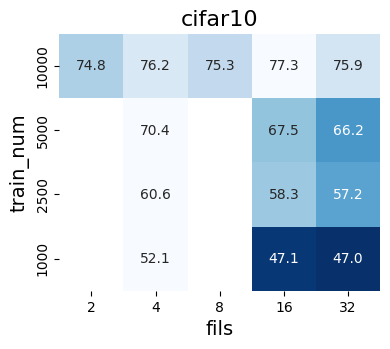

In [9]:
df = df_base


# df = df.filter(pl.col("train_dataset") == "cifar10_train")

datasets = df["train_dataset"].unique()
ndatas = df["train_num"].unique()


for dataset in datasets:
    # for ndata in ndatas:
        df_ds = df.filter(pl.col("train_dataset") == dataset)
        # df_ds = df_ds.filter(pl.col("train_num") == ndata)

        piv_index = "fils"
        piv_columns = "train_num"
        # piv_index = "train_num"
        # piv_columns = "fils"
        
        df_piv = df_ds.pivot(values="val_acc", index=piv_index, on=piv_columns, sort_columns=True)
        df_piv_diff = df_piv.with_columns((pl.all().exclude(piv_index) - pl.all().exclude(piv_index).min()).name.keep())
        df_piv_diff = df_piv.with_columns((pl.all().exclude(piv_index) / pl.all().exclude(piv_index).max()).name.keep())

        df_piv_ind = pl.Series(df_piv.columns[1:]).cast(pl.Int32)
        df_piv = df_piv.transpose(include_header=False, column_names=df_piv[piv_index].cast(pl.String))[1:]


        df_piv = pl.concat([pl.DataFrame({piv_columns: df_piv_ind}), df_piv], how="horizontal")
        df_piv = df_piv.sort(by=piv_columns, descending=True)
        
        df_piv_diff_ind = pl.Series(df_piv_diff.columns[1:]).cast(pl.Int32)
        df_piv_diff = df_piv_diff.transpose(include_header=False, column_names=df_piv_diff[piv_index].cast(pl.String))[1:]
        df_piv_diff = pl.concat([pl.DataFrame({piv_columns: df_piv_diff_ind}), df_piv_diff], how="horizontal")
        df_piv_diff = df_piv_diff.sort(by=piv_columns, descending=True)

        df_piv_val = df_piv.select([str(num) for num in sorted(df_piv.columns[1:], key=float)])
        df_piv_diff_val = df_piv_diff.select([str(num) for num in sorted(df_piv_diff.columns[1:], key=float)])
        
        fig, ax = plt.subplots(figsize=(len(df_piv.columns)/1.2, len(df_piv)/1.2))
        ax = sns.heatmap(df_piv_diff_val, annot=df_piv_val*100, cbar=False, square=True, cmap="Blues_r", xticklabels=pl.Series(df_piv_val.columns), yticklabels=df_piv[piv_columns], fmt=".1f")
        # ax = sns.heatmap(df_piv_val, annot=df_piv_val*100, cbar=True, square=True, cmap="Blues_r", xticklabels=pl.Series(df_piv_val.columns).str.head(4), yticklabels=df_piv_ind, fmt=".2f")

        # ax.set_title(f"{dataset[:-6]}, {ndata}data", fontsize=16)
        ax.set_title(f"{dataset[:-6]}", fontsize=16)
        ax.set_xlabel(piv_index, fontsize=14)
        ax.set_ylabel(piv_columns, fontsize=14, rotation=90)
        plt.show()
